In [2]:
import sys
sys.path.append('../cpp_code')
import cgoss
from sklearn.linear_model import LogisticRegression
import numpy as np

In [3]:
import dill
import pickle
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn import metrics
logreg = LogisticRegression()
"sklearn" in str(type(logreg))
from sklearn.neighbors import KNeighborsClassifier

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
class Voter:
    """A customer ensemble voting classifier"""
    def __init__(self, models, pf = None ):
        self.delimiter = .5
        self.models = models
        self.pf = pf
        
    def predict_proba_soft(self, x):
        import sys
        sys.path.append('../cpp_code')
        import cgoss
        import xgboost as xgb
        from sklearn.ensemble import ExtraTreesClassifier
        from sklearn.model_selection import GridSearchCV
        from sklearn.preprocessing import PolynomialFeatures
        from sklearn.linear_model import LogisticRegression
        probas = []
        for line in x:
            prob = self.delimiter
            base = 0.5
            for m in self.models:

                if "sklearn" in str(type(m)) and ('KNeighborsClassifier' not in str(type(m)) and 'Extra' not in str(type(m)) ):
                    if len(m.coef_[0]) > len (line):
                        l = self.pf.transform(line.reshape(1, -1))
                        pred =  m.predict_proba(l)[0][1]
                        prob = cgoss.max_distance(prob, pred, self.delimiter)
                    else:
                        pred =  m.predict_proba(line.reshape(1, -1))[0][1]
                        prob = cgoss.max_distance(prob, pred, self.delimiter)
                elif "GridSearchCV" in str(type(m)): 
                    pred =  m.predict_proba(line.reshape(1, -1))[0][1]
                    prob = cgoss.max_distance(prob, pred, self.delimiter)    
                
                elif "xgboost" in str(type(m)):
                    D = xgb.DMatrix(line.reshape(1, -1))
                    pred =  cgoss.scale_confidence(m.predict(D), .0)
                    prob = cgoss.max_distance(prob, pred, self.delimiter)
                elif "Extra" in str(type(m)):
                    pred =  cgoss.scale_confidence(m.predict(line.reshape(1,-1)), .0)
                    prob = cgoss.max_distance(prob, pred, self.delimiter)
                else:
                    pred =  m.predict(line.reshape(1,-1))
                    prob = cgoss.max_distance(prob, pred, self.delimiter)
            probas.append(prob)
        return probas 



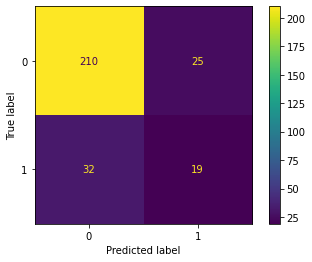

In [6]:
with open('../pickles/train_test_rs.pkl', 'rb') as pickle_in:
    X_train, X_test, y_train, y_test = pickle.load(pickle_in)
with open('../pickles/gs.pkl', 'rb') as pickle_in:
    gs = pickle.load(pickle_in)    

logreg2 = LogisticRegression(C=0.5,)    
pf = PolynomialFeatures(3)
X_tr = pf.fit_transform(X_train)
X_te= pf.transform(X_test)
logreg2.fit(X_tr, y_train)
metrics.plot_confusion_matrix(logreg2, X_te, y_test)

0.6814701378254211 0.7700810611643331
0.6078431372549019 0.8041958041958042


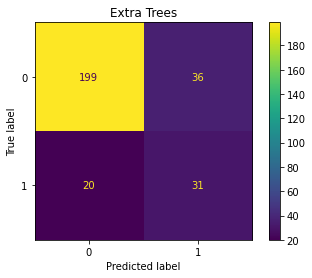

In [7]:
xt = ExtraTreesClassifier(min_impurity_decrease=.001, min_samples_leaf=100, random_state=60, max_depth=4, bootstrap=True)
xt.fit(X_train, y_train)
print(metrics.recall_score(y_train, xt.predict(X_train)), metrics.accuracy_score(y_train, xt.predict(X_train)))
print(metrics.recall_score(y_test, xt.predict(X_test)), metrics.accuracy_score(y_test, xt.predict(X_test)))
metrics.plot_confusion_matrix(xt, X_test, y_test)
plt.title("Extra Trees")
plt.savefig('../output/xt.png')

1.0 1.0
0.5294117647058824 0.7447552447552448


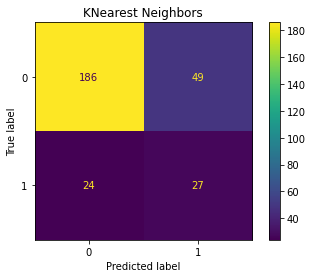

In [8]:
knn = KNeighborsClassifier(n_neighbors = 100, weights = 'distance')
knn.fit(X_train, y_train)
metrics.plot_confusion_matrix(knn, X_test, y_test)
print(metrics.recall_score(y_train, knn.predict(X_train)), metrics.accuracy_score(y_train, knn.predict(X_train)))
print(metrics.recall_score(y_test, knn.predict(X_test)), metrics.accuracy_score(y_test, knn.predict(X_test)))
plt.title("KNearest Neighbors")
plt.savefig('../output/knn.png')

0.774885145482389 0.8054532056005895
0.7254901960784313 0.7657342657342657


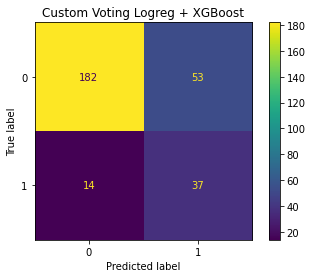

In [9]:

    
logreg =LogisticRegression()
param = {'max_depth': 2, }
    
D_train = xgb.DMatrix(X_train, label=y_train)
bst = xgb.train(param, D_train)
logreg.fit(X_train, y_train)
voter = Voter([ logreg, bst])
vpreds = voter.predict_proba_soft(X_test)
filt = 0.5
vpreds =[ 1 if i > filt else 0 for i in  vpreds]
con  = metrics.confusion_matrix(y_test, vpreds)
metrics.ConfusionMatrixDisplay(con).plot();
vpreds = voter.predict_proba_soft(X_train)
filt = 0.5
vpreds =[ 1 if i > filt else 0 for i in  vpreds]
print(metrics.recall_score(y_train, vpreds), metrics.accuracy_score(y_train, vpreds))
vpreds = voter.predict_proba_soft(X_test)
filt = 0.5
vpreds =[ 1 if i > filt else 0 for i in  vpreds]
print(metrics.recall_score(y_test, vpreds), metrics.accuracy_score(y_test, vpreds))
plt.title("Custom Voting Logreg + XGBoost")
plt.savefig('../output/logreg-xgb.png')

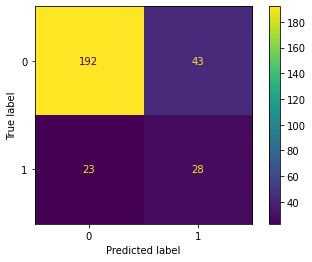

In [10]:
D = xgb.DMatrix(X_test)
pred =  bst.predict(D)
filt = 0.5
pred =[ 1 if i > filt else 0 for i in  pred]
con  = metrics.confusion_matrix(y_test, pred)
metrics.ConfusionMatrixDisplay(con).plot();


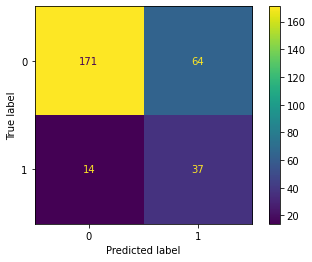

In [11]:
metrics.plot_confusion_matrix(logreg, X_test, y_test)

In [12]:
with open('../pickles/voter.pkl', 'wb') as pickle_out:
    dill.dump(voter, pickle_out)

In [32]:
import pandas as pd
df2 = pd.read_csv('../data/survey-results.csv')
df3 = pd.read_csv('../data/survey-results.csv')
df2.dropna(inplace=True)
df3.dropna(inplace=True)
df2.drop(columns='EmployeeNumber', inplace=True)
df2 = pd.get_dummies(df2, columns = ['EducationField'] )
with open('../pickles/sc.pkl', 'rb') as pickle_in:
    sc = pickle.load(pickle_in)
X = sc.fit_transform(df2.drop(columns=['Attrition']))
filt = 0.5
pred = voter.predict_proba_soft(X)
df3['pred'] =  [ 1 if i > filt else 0 for i in  pred]
df3['proba'] = pred


{}

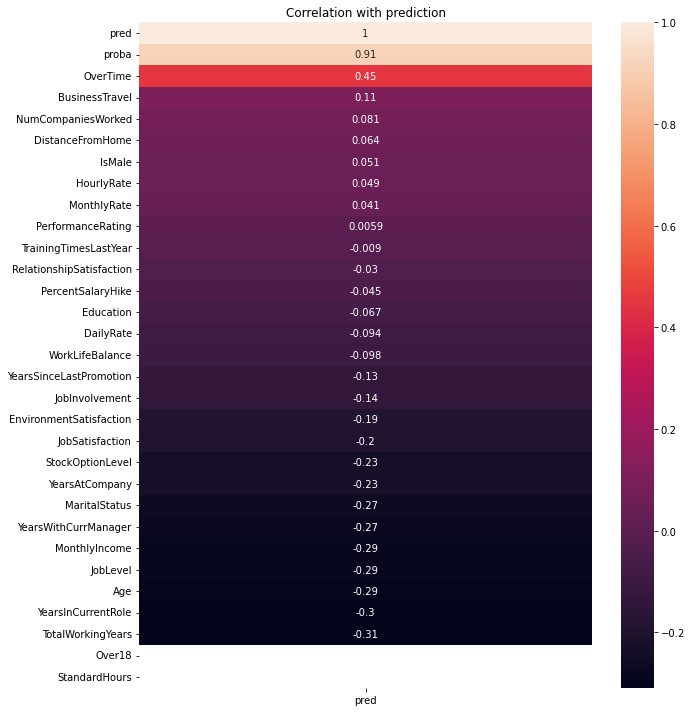

In [33]:
import seaborn as sns
df3.drop(columns=['Attrition', 'EmployeeNumber'], inplace=True)
c = df3.corr()
plt.figure(figsize=(10,10))
sns.heatmap(c[['pred']].sort_values('pred', ascending = False),annot=True);
plt.title('Correlation with prediction')
plt.tight_layout()
plt.savefig('../output/heatmap_preds.png');